In [ ]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

In [ ]:
!pip install pytorch_lightning &> /dev/null

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from scipy import ndimage
from functools import partial
import copy
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.patches as patches
from scipy.interpolate import make_interp_spline, BSpline
import cv2

class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone

        self.category_branch = nn.ModuleList([nn.Sequential(torch.nn.Conv2d(256,256,kernel_size=3,padding=1, stride=1, bias=False), torch.nn.GroupNorm(32, 256), torch.nn.ReLU(inplace = False)) for i in range(7)])
        
        self.category_out = nn.Sequential(torch.nn.Conv2d(256, 3,kernel_size=3,padding=1, bias=True), torch.nn.Sigmoid())
        
        self.instance_branch  = nn.ModuleList()
        self.instance_branch.append(nn.Sequential(torch.nn.Conv2d(256+2,256,kernel_size=3,padding=1, stride=1, bias=False), torch.nn.GroupNorm(32, 256), torch.nn.ReLU(inplace = False)))
        self.instance_branch.extend([nn.Sequential(torch.nn.Conv2d(256,256,kernel_size=3,padding=1, stride=1, bias=False), torch.nn.GroupNorm(32, 256), torch.nn.ReLU(inplace = False)) for i in range(6)])
        self.instance_out = nn.ModuleList()
        for g in self.num_grids:
            self.instance_out.append(nn.Sequential(torch.nn.Conv2d(256, g**2, kernel_size=1, bias=True),torch.nn.Sigmoid()))

        self._init_weights()
    
    def init_weights(self, l):
        if type(l) == nn.Conv2d:
          nn.init.xavier_uniform_(l.weight)
          if l.bias != None:
            l.bias.data.fill_(0)

           
    def _init_weights(self):
        ## TODO: initialize the weights
        self.category_branch.apply(self.init_weights)
        self.instance_branch.apply(self.init_weights)
        self.category_out.apply(self.init_weights)        
        for i in self.instance_out:
          i.apply(self.init_weights)  
    ## Loss functions
    def focal_loss(self, cate_preds, cate_gts):

      eps = 0.0000001
      cate_gts = cate_gts.type(torch.LongTensor)
      one_hot  = torch.nn.functional.one_hot(cate_gts, num_classes=4)
      cate_gts_unflattened = one_hot[:,1:]
      #print("cate_gts_unflattened", cate_gts_unflattened.shape)
      #print("one hot", one_hot.shape)
      pt = torch.flatten(cate_preds) 
      #print(pt)
      cate_gts_flattened   = torch.flatten(cate_gts_unflattened)

      #print("cate_gts", cate_gts.shape)
      #print("pt", pt.shape)

      factor = 0.25
      gamma = 2

      a = torch.ones(cate_gts_flattened.shape,device=device) * factor

      idx = cate_gts_flattened<1
      a[idx]  = 1 - a[idx] 
      pt[idx] = 1 - pt[idx]

      fl = (torch.sum(-a*(torch.pow((1-pt),gamma))*torch.log(pt+eps)) + eps)/(cate_gts.shape[0]*3)
      
      return fl

    def dice_loss(self, mask_pred, mask_gt):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      dice_loss = torch.tensor(0, dtype=torch.float32).to(device)
      active_cells = 0
      eps = 0.0001
      for i in range(len(mask_pred)):
        active_cells += mask_pred[i].shape[0]
        for m in range(mask_pred[i].shape[0]):
            m_pred = mask_pred[i][m].to(device)
            m_gt   = mask_gt[i][m].to(device)
            dl = (2*torch.sum(m_pred * m_gt))/(torch.sum(torch.pow(m_pred,2)) + torch.sum(torch.pow(m_gt,2)))# + eps) 
            dice_loss += (1.0-dl)

      if active_cells == 0:
        return dice_loss
      return dice_loss/active_cells

    def loss(self, cate_pred_list, ins_pred_list, ins_gts_list, ins_ind_gts_list, cate_gts_list):
      ins_gts = [torch.cat([ins_labels_level_img[ins_ind_labels_level_img, ...] for ins_labels_level_img, ins_ind_labels_level_img in zip(ins_labels_level, ins_ind_labels_level)], 0)
                for ins_labels_level, ins_ind_labels_level in zip(zip(*ins_gts_list), zip(*ins_ind_gts_list))]
        
      ins_preds = [torch.cat([ins_preds_level_img[ins_ind_labels_level_img, ...] for ins_preds_level_img, ins_ind_labels_level_img in zip(ins_preds_level, ins_ind_labels_level)], 0) 
                  for ins_preds_level, ins_ind_labels_level in zip(ins_pred_list, zip(*ins_ind_gts_list))]
                    
      cate_gts = [torch.cat([cate_gts_level_img.flatten() for cate_gts_level_img in cate_gts_level])
                  for cate_gts_level in zip(*cate_gts_list)]
                    
      cate_gts = torch.cat(cate_gts)
      cate_preds = [cate_pred_level.permute(0,2,3,1).reshape(-1, self.num_classes - 1) for cate_pred_level in cate_pred_list]
      cate_preds = torch.cat(cate_preds, 0)

      fl = self.focal_loss(cate_preds, cate_gts)
      dl = self.dice_loss(ins_preds, ins_gts)

      return fl, self.mask_loss_cfg['weight'] * dl
    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward_one_level(self, fpn_feat, idx, eval=True, upsample_shape=None):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        cate_pred = fpn_feat
        ins_pred  = torch.zeros((fpn_feat.shape[0], fpn_feat.shape[1]+2, fpn_feat.shape[2], fpn_feat.shape[3])).to(device) 
        ins_pred[:,:fpn_feat.shape[1],:,:] = fpn_feat
        num_grid = self.num_grids[idx]  


        cate_pred = torch.nn.functional.interpolate(cate_pred, (num_grid, num_grid))
        for i, l in enumerate(self.category_branch):
            cate_pred = l(cate_pred) 
        
        cate_pred = self.category_out(cate_pred)
        
        coord_y,coord_x = torch.meshgrid([torch.linspace(0.0, 1.0, fpn_feat.shape[2]), torch.linspace(0.0, 1.0, fpn_feat.shape[3])])
        
        ins_pred[:,fpn_feat.shape[1],:,:]   = coord_x
        ins_pred[:,fpn_feat.shape[1]+1,:,:] = coord_y 
        
        
        for i, l in enumerate(self.instance_branch):
            ins_pred = l(ins_pred)

        ins_pred = torch.nn.functional.interpolate(ins_pred, (fpn_feat.shape[2]*2, fpn_feat.shape[3]*2), 
                                                   mode='bilinear', align_corners=True)        
        ins_pred = self.instance_out[idx](ins_pred)
        
        if eval == True:
            ins_pred = torch.nn.functional.interpolate(ins_pred, upsample_shape)
            cate_pred = points_nms(cate_pred).permute(0,2,3,1)

        return cate_pred, ins_pred         
        
        
    def forward(self, images, eval=True):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        new_feature_pyramid = []
        new_feature_pyramid.append(torch.nn.functional.interpolate(feature_pyramid[0], size=(feature_pyramid[1].shape[2], feature_pyramid[1].shape[3]), mode='bilinear'))                        
        new_feature_pyramid.append(feature_pyramid[1])
        new_feature_pyramid.append(feature_pyramid[2])
        new_feature_pyramid.append(feature_pyramid[3])
        new_feature_pyramid.append(torch.nn.functional.interpolate(feature_pyramid[4], size=(feature_pyramid[3].shape[2], feature_pyramid[3].shape[3]), mode='bilinear'))
        
        q_shape = [new_feature_pyramid[0].shape[-2]*2, new_feature_pyramid[0].shape[-1]*2]
        
        forward_one_level_partial = partial(self.forward_one_level, eval=eval, upsample_shape=q_shape)
        mapped_pyramid_out = map(forward_one_level_partial, new_feature_pyramid, list(range(len(new_feature_pyramid))))
        self.predicted_tuple = tuple(map(list, zip(*mapped_pyramid_out)))

        del feature_pyramid
        return self.predicted_tuple
        
    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    def generate_targets(self, bounding_boxes, labels, masks):
      featmap_sizes = []
      ins_pred_list = self.predicted_tuple[1]
      for i,pred in enumerate(ins_pred_list):
        featmap_sizes.append([ins_pred_list[i].shape[2], ins_pred_list[i].shape[3]] )
        
      featmap_sizes = [featmap_sizes for i in range(len(masks))]

      output = map(self.generate_target, bounding_boxes, labels, masks, featmap_sizes)
      ins_gts_list, ins_ind_gts_list, cate_gts_list = tuple(map(list, zip(*output)))
      
      del featmap_sizes
      del ins_pred_list
      del bounding_boxes
      del labels
      del masks
      return ins_gts_list, ins_ind_gts_list, cate_gts_list


    def generate_target(self, bounding_boxes, labels, masks, featmap_sizes):
      h, w = masks.shape[2], masks.shape[3]

      area   = torch.sqrt((bounding_boxes[:,2] - bounding_boxes[:,0]) * (bounding_boxes[:,3] - bounding_boxes[:,1]))
      region = torch.zeros((masks.shape[0],4))

      for i in range(masks.shape[0]):
          centre_of_mass = ndimage.measurements.center_of_mass(masks[i,0,:,:].numpy()) 
          region[i, 0] = centre_of_mass[1]
          region[i, 1] = centre_of_mass[0]

      region[:,2] = (bounding_boxes[:,2] - bounding_boxes[:,0]) *0.2/w         
      region[:,3] = (bounding_boxes[:,3] - bounding_boxes[:,1]) *0.2/h          
      
      region[:,0] = region[:,0]/w 
      region[:,1] = region[:,1]/h
      

      ins_label_list = []
      ins_ind_label_list = []
      cate_label_list = []

      for i, size in enumerate(featmap_sizes):
          if (i==0):
              idx = area<96
          elif i==1:
              idx = torch.logical_and(area<192,area>48)
          elif i==2: 
              idx = torch.logical_and(area<384,area>96)
          elif i==3: 
              idx = torch.logical_and(area<768,area>192)
          elif i==4: 
              idx = area>=384
          
          if torch.sum(idx) == 0:
              cat_label = torch.zeros((self.num_grids[i],self.num_grids[i]))
              ins_label = torch.zeros((self.num_grids[i]**2, size[0], size[1]))
              ins_index_label = torch.zeros(self.num_grids[i]**2, dtype=torch.bool)

              cate_label_list.append(cat_label)
              ins_label_list.append(ins_label)
              ins_ind_label_list.append(ins_index_label)
              
              continue
          
          region_idx = region[idx,:]
          left_ind   = ((region_idx[:,0] - region_idx[:,2]/2)*self.num_grids[i]).int()
          right_ind  = ((region_idx[:,0] + region_idx[:,2]/2)*self.num_grids[i]).int()
          top_ind    = ((region_idx[:,1] - region_idx[:,3]/2)*self.num_grids[i]).int()
          bottom_ind = ((region_idx[:,1] + region_idx[:,3]/2)*self.num_grids[i]).int()

          left   = torch.max(torch.zeros_like(left_ind)                              , left_ind  )
          right  = torch.min(torch.ones_like(right_ind)*(self.num_grids[i] - 1)  , right_ind )
          top    = torch.max(torch.zeros_like(top_ind)                               , top_ind   )
          bottom = torch.min(torch.ones_like(bottom_ind)*(self.num_grids[i] - 1) , bottom_ind)

          xA = torch.max(left    , (region_idx[:,0]*self.num_grids[i]).int() - 1)
          xB = torch.min(right   , (region_idx[:,0]*self.num_grids[i]).int() + 1)
          yA = torch.max(top     , (region_idx[:,1]*self.num_grids[i]).int() - 1)
          yB = torch.min(bottom  , (region_idx[:,1]*self.num_grids[i]).int() + 1)

          cat_label = torch.zeros((self.num_grids[i],self.num_grids[i]))

          ins_label = torch.zeros((self.num_grids[i]**2, size[0], size[1]))
          
          ins_index_label = torch.zeros(self.num_grids[i]**2, dtype=torch.bool)

          mask_interpolate = torch.nn.functional.interpolate(masks[idx,:,:,:],
                                                              (size[0],size[1]))
          mask_interpolate[mask_interpolate > 0.5] = 1
          mask_interpolate[mask_interpolate < 0.5] = 0

          for j in range(xA.size(0)):

            cat_label[yA[j]:yB[j]+1 , xA[j]:xB[j]+1] = labels[idx][j]
            
            flag_matrix = torch.zeros(cat_label.shape)

            flag_matrix[yA[j]:yB[j]+1 , xA[j]:xB[j]+1] = 1
            positive_index = (torch.flatten(flag_matrix) > 0)

            ins_label[positive_index,:,:] = mask_interpolate[j,0,:,:]

            ins_index_label = torch.logical_or(ins_index_label,positive_index)

          cate_label_list.append(cat_label)
          ins_label_list.append(ins_label)
          ins_ind_label_list.append(ins_index_label)
          
      return ins_label_list, ins_ind_label_list, cate_label_list
        

### Edit the Path Variables Here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

imgs_path = 'mycocodata_img_comp_zlib.h5'
masks_path = 'mycocodata_mask_comp_zlib.h5'
labels_path = "mycocodata_labels_comp_zlib.npy"
bboxes_path = "mycocodata_bboxes_comp_zlib.npy"    
paths = [imgs_path, masks_path, labels_path, bboxes_path]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path):

        self.img    = h5py.File(path[0],'r')['data']
        self.mask   = h5py.File(path[1],'r')['data']
        self.labels = np.load(path[2], allow_pickle=True)
        self.bbox   = np.load(path[3], allow_pickle=True)
           
        self.normalize = transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        
        self.aligned_masks = [] 
        
        i = 0 
        mask_shape = self.mask[0].shape
        for l in range(self.labels.shape[0]):
            length = self.labels[l].size
            clubbed_mask = []
            for idx in range(length):
                clubbed_mask.append(self.mask[i,:,:])
                i+=1
                
            self.aligned_masks.append(clubbed_mask)

    def __getitem__(self, index):

        img   = self.img[index,:,:,:]
        label = self.labels[index]
        mask  = self.aligned_masks[index]
        bbox  = self.bbox[index]
        label = torch.tensor(label, dtype=torch.float)
        transed_img, transed_mask, transed_bbox = self.pre_process_batch(img, mask, bbox)

        return transed_img, label, transed_mask, transed_bbox 
    
    def __len__(self):
        return self.img.shape[0]

    def pre_process_batch(self, img, mask, bbox):

        scale_factor_x = 800/300
        scale_factor_y = 1066/400
        
        transed_img   = torch.tensor(img.astype(np.float), dtype=torch.float)
        transed_bbox  = torch.tensor(bbox, dtype=torch.float)
            
        transed_img =  transed_img/255.0
        transed_img =  torch.unsqueeze(transed_img, 0)
        transed_img  = torch.nn.functional.interpolate(transed_img, size=(800, 1066), mode='bilinear') #Interpolation
        transed_img =  self.normalize(transed_img[0])
        transed_img =  torch.nn.functional.pad(transed_img, pad=(11,11), mode='constant',value=0)

        transed_masks = torch.zeros((len(mask),3,800,1088))
        for i, m in enumerate(mask):
            transed_mask = torch.tensor(m.astype(np.uint8), dtype=torch.float)
            transed_mask = torch.unsqueeze(transed_mask, 0)
            transed_mask = torch.cat(3*[transed_mask])
            transed_mask = torch.unsqueeze(transed_mask, 0)
            transed_mask = torch.nn.functional.interpolate(transed_mask,size=(800, 1066), mode='bilinear')
            transed_mask = torch.nn.functional.pad(transed_mask, pad=(11,11), mode='constant',value=0)
            transed_mask[transed_mask > 0.5] = 1
            transed_mask[transed_mask < 0.5] = 0
            transed_masks[i] = transed_mask[0,0,:,:]

        transed_bbox[:,0] = transed_bbox[:,0] * scale_factor_x
        transed_bbox[:,2] = transed_bbox[:,2] * scale_factor_x
        transed_bbox[:,1] = transed_bbox[:,1] * scale_factor_y
        transed_bbox[:,3] = transed_bbox[:,3] * scale_factor_y
        transed_bbox[:,0] += 11 
        transed_bbox[:,2] += 11 

        assert transed_img.shape == (3, 800, 1088)
        assert transed_bbox.shape[0] == transed_masks.shape[0]
        return transed_img, transed_masks, transed_bbox

        
class CustomDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    def collect_fn(self, batch):
        bz = len(batch)
        transed_img_list = []
        label_list = []
        transed_mask_list = []
        transed_bbox_list = []

        for transed_img, label, transed_mask, transed_bbox in batch:
          transed_img_list.append(transed_img)
          label_list.append(label)
          transed_mask_list.append(transed_mask)
          transed_bbox_list.append(transed_bbox)

        return torch.stack(transed_img_list, dim = 0), \
                label_list,\
                transed_mask_list,\
                transed_bbox_list

    def loader(self):
        
        return torch.utils.data.DataLoader(self.dataset, 
                                    batch_size= self.batch_size, 
                                    shuffle= self.shuffle, 
                                    sampler=None, 
                                    batch_sampler=None, 
                                    num_workers= self.num_workers, 
                                    collate_fn= self.collect_fn)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = CustomDataset(paths)
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(0)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
train_build_loader = CustomDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # reset Shuffle to True
train_loader = train_build_loader.loader()
test_build_loader = CustomDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

mask_color_list = ["jet", "ocean", "Spectral", "spring", "cool"]

#### Dataset visualization

In [ ]:
def data_viz():
  count=0
  for iter, data in enumerate(train_loader, 0):

          img, label, mask, bbox = [data[i] for i in range(len(data))]
          # check flag
          assert img.shape == (batch_size, 3, 800, 1088)
          assert len(mask) == batch_size

          label = [label_img.to(device) for label_img in label]
          mask = [mask_img.to(device) for mask_img in mask]
          bbox = [bbox_img.to(device) for bbox_img in bbox]

          invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                      std = [ 1., 1., 1. ]),
                                ])

          for i in range(batch_size):     
              if label[i].shape[0]<=1:
                continue
              count+=1
              combined_mask = np.zeros((img.shape[2],img.shape[3],img.shape[1]))

              fig = plt.figure()
              ax = fig.add_subplot(111)

              for j, l in enumerate(label[i]):
                xA, xB, yA, yB = bbox[i][j,0].item(), bbox[i][j,2].item(), bbox[i][j,1].item(), bbox[i][j,3].item()
              
                if l == 1:
                    combined_mask[:,:,0] += (mask[i][j,0,:,:] * 255).cpu().numpy()
                    rect = patches.Rectangle((xA,yA), xB-xA, yB-yA, linewidth=1, edgecolor='r',facecolor='none')
                if l == 2:
                    combined_mask[:,:,1] += (mask[i][j,1,:,:] * 255).cpu().numpy()
                    rect = patches.Rectangle((xA,yA), xB-xA, yB-yA, linewidth=1, edgecolor='g',facecolor='none')
                if l == 3: 
                    combined_mask[:,:,2] += (mask[i][j,2,:,:] * 255).cpu().numpy()
                    rect = patches.Rectangle((xA,yA), xB-xA, yB-yA, linewidth=1, edgecolor='b',facecolor='none')
                ax.add_patch(rect)
              temp = invTrans(img[i,:,:,:])
            
              origin_img = invTrans(img[i,:,:,:]).numpy().transpose(1,2,0)
              mask_to_plot = combined_mask + (origin_img*(1 - (combined_mask/255))*255)
              ax.imshow(origin_img)
              ax.imshow(np.uint8(mask_to_plot),alpha = 0.5)
              plt.show()

          if count == 10:
            break

In [ ]:
# import logging
def plot_gt_target(ins_gts_list, ins_ind_gts_list, cate_gts_list, mask_color_list, img):
  # logger = logging.getLogger()
  # oldlevel = logger.level
  # logger.setLevel(100)
  num_pyramids = len(ins_gts_list[0])
  fig = plt.figure(figsize=(10,10))
  
  for i in range(num_pyramids):
    plt.subplot(3,2,i+1)

    plt.imshow(np.clip(img[0,:,:,:].cpu().numpy().transpose(1,2,0), 0, 1))

    if sum(ins_ind_gts_list[0][i]) == 0:
      continue

    index = ins_ind_gts_list[0][i] > 0
    label = torch.flatten(cate_gts_list[0][i])[index]
    mask = ins_gts_list[0][i][index,:,:]
    mask = torch.unsqueeze(mask,1)
    
    reshaped_mask = torch.nn.functional.interpolate(mask,(img.shape[2],img.shape[3]),mode='bilinear')
    
    combined_mask = np.zeros((img.shape[2],img.shape[3],img.shape[1]))

    for idx,l in enumerate(label):
      if l == 1:
        combined_mask[:,:,0] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
      if l == 2:
        combined_mask[:,:,1] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
      if l == 3:
        combined_mask[:,:,2] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
    
    origin_img = img[0,:,:,:].cpu().numpy().transpose(1,2,0)
    index_to_mask = np.where(combined_mask > 0)
    masked_image = copy.deepcopy(origin_img)
    masked_image[index_to_mask[0],index_to_mask[1],:] = 0

    mask_to_plot = (combined_mask + masked_image)
    plt.imshow(mask_to_plot)
  plt.show()
  # logger.setLevel(oldlevel)

#### Target visualization

In [ ]:
def target_viz():
  check = 0
  for iter, data in enumerate(train_loader, 0): #list of batch_size, mask: 1x3x800x1088, bbox: 1x4, target:
    img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
    for lbl in label_list:
      if len(lbl)>1:
        img = img.to(device)
        ##### Target Assignment Visualization
        cate_pred_list, ins_pred_list = solo.forward(img, eval=True)
        ins_gts_list, ins_ind_gts_list, cate_gts_list = solo.generate_targets(bbox_list, label_list, mask_list)

        mask_color = ["jet", "ocean", "Spectral"]

        plot_gt_target(ins_gts_list, ins_ind_gts_list, cate_gts_list, mask_color, img)
        check +=1
        if check == 7:
          return

#### Single cell evaluation to reproduce the results

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Visualizing The Dataset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


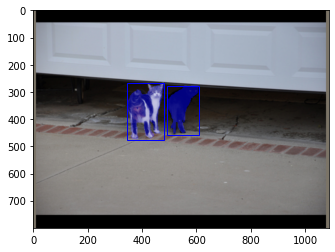

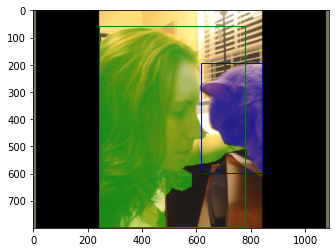

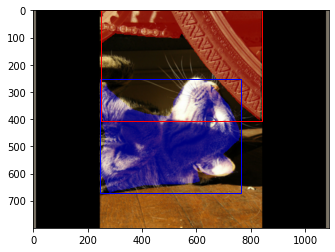

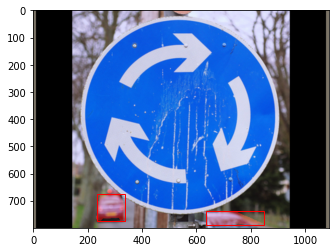

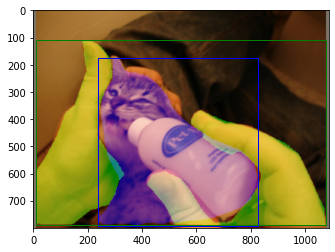

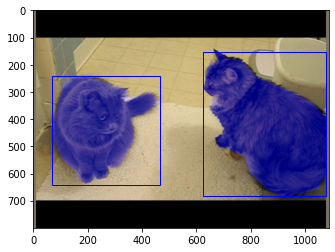

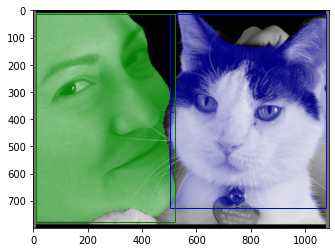

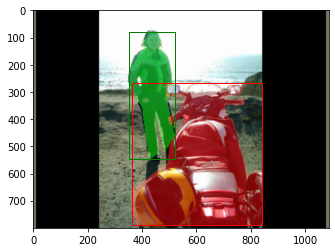

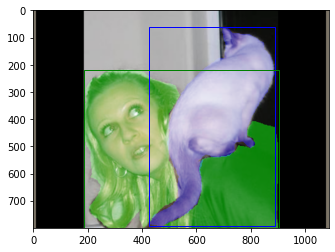

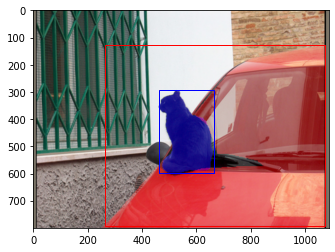

In [ ]:
solo = SOLO().to(device)

print("Visualizing The Dataset")
data_viz()

# print("Visualizing Target Assignments")
# target_viz()

In [ ]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

## function for concatenation and sorting
def concat_sort(ins_pred_list, cate_pred_list, ori_size):
  #taken from solo
  postprocess_cfg= dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
  
  ins_pred  = ins_pred_list[0]
  cate_pred = torch.reshape(cate_pred_list[0], (cate_pred_list[0].shape[0], cate_pred_list[0].shape[1] * cate_pred_list[0].shape[2], cate_pred_list[0].shape[3]))  
  # print(cate_pred.shape)
  bz = ins_pred.shape[0] 

  for i in range(1, len(ins_pred_list)):
    ins_pred = torch.cat((ins_pred, ins_pred_list[i]), dim=1)
    # print(cate_pred.shape)
    # print((cate_pred_list[i].shape[0], cate_pred_list[i].shape[1] * cate_pred_list[i].shape[2], cate_pred_list[i].shape[3]))
    cate_pred = torch.cat((cate_pred, torch.reshape(cate_pred_list[i], (cate_pred_list[i].shape[0], cate_pred_list[i].shape[1] * cate_pred_list[i].shape[2], cate_pred_list[i].shape[3]))),dim=1)

  NMS_sorted_scores_list = []
  NMS_sorted_cate_label_list = []
  NMS_sorted_ins_list = []
  for i in range(bz):

      cmax,label = torch.max(cate_pred[i], dim=1)
      idx = cmax > postprocess_cfg["cate_thresh"]

      if(idx.sum() == 0):
        nms_sorted_scores, nms_sorted_category_label, nms_sorted_ins_label = torch.tensor([0]), torch.tensor([1]), torch.zeros((1,800,1088))

      gt_ins_thresh = ins_pred[i] > postprocess_cfg["mask_thresh"]
      ins_pred[i] = ins_pred[i] * gt_ins_thresh
      
      scores = torch.sum(ins_pred[i], dim=(1,2))*cmax/torch.sum(gt_ins_thresh,dim=(1,2))
      nan_scores_idx = torch.isnan(scores)
      scores[nan_scores_idx] = 0

      scores_filtered = scores[idx]
      masks_filtered  = ins_pred[i][idx,:,:]
      label_filtered  = label[idx]  

      sorted_scores, sorted_indices = torch.sort(scores_filtered, descending = True)

      nms_scores = MatrixNMS(masks_filtered[sorted_indices], sorted_scores)

      nms_score_thresh= 0.3
      nms_scores[nms_scores<nms_score_thresh] = 0
      nms_sorted_scores, nms_sorted_indices = torch.sort(nms_scores, descending = True)

      nms_sorted_category_label = label_filtered[sorted_indices[nms_sorted_indices]]
      nms_sorted_ins_label      = masks_filtered[sorted_indices[nms_sorted_indices],:,:]
      
      nms_sorted_ins_label[nms_sorted_ins_label > postprocess_cfg["mask_thresh"]] = 1
      nms_sorted_ins_label[nms_sorted_ins_label < postprocess_cfg["mask_thresh"]] = 0

      nms_sorted_ins_label = torch.nn.functional.interpolate(nms_sorted_ins_label.unsqueeze(0), ori_size)
    

      idx = nms_sorted_scores>0
      nms_sorted_scores = nms_sorted_scores[idx]
      nms_sorted_category_label = nms_sorted_category_label[idx] + 1
      nms_sorted_ins_label= nms_sorted_ins_label.squeeze(0)[idx]
 
      NMS_sorted_scores_list.append(nms_sorted_scores)
      NMS_sorted_cate_label_list.append(nms_sorted_category_label)
      NMS_sorted_ins_list.append(nms_sorted_ins_label)

  return NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = CustomDataset(paths)
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(0)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
tb_loader = CustomDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # reset Shuffle to True
train_loader = tb_loader.loader()
testb_loader = CustomDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = testb_loader.loader()

epochs= 36
learning_rate = 0.01
resume = False
path_model = "/content/drive/My Drive/"
start_epoch = 0

solo = SOLO().to(device)
optimizer = torch.optim.Adam(solo.parameters(), lr=learning_rate, weight_decay = 0.0001)

diceloss_train_list, focalloss_train_list, totalloss_train_list = [], [], []
diceloss_val_list, focalloss_val_list, totalloss_val_list = [], [], []

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

In [ ]:
if resume == True:
      checkpoint = torch.load(path_model)
      solo.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      start_epoch = checkpoint['epoch']

torch.cuda.empty_cache()
for epoch in range(start_epoch, epochs):
  solo.train()
  for iter, data in enumerate(train_loader, 0):
    img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
    img = img.to(device)
  
    cate_pred_list, ins_pred_list = solo.forward(img, eval=False)
    ins_gts_list, ins_ind_gts_list, cate_gts_list = solo.generate_targets(bbox_list, label_list, mask_list)

    fl, dl = solo.loss(cate_pred_list, ins_pred_list, ins_gts_list, 
                            ins_ind_gts_list, cate_gts_list)
    loss = fl + dl
    loss.backward()
    totalloss_train_list.append(loss.item())
    focalloss_train_list.append(fl.item())
    diceloss_train_list.append(dl.item())

    del img, label_list, mask_list, bbox_list, ins_gts_list, ins_ind_gts_list, cate_gts_list, cate_pred_list, ins_pred_list
    torch.cuda.empty_cache()
    optimizer.step()
    optimizer.zero_grad()
    if ((iter+1) % 50) == 0:
      print('\nepoch: ', epoch, 'iter: ',iter, 'FL: ', sum(focalloss_train_list[-50:])/50 , 'DL: ', sum(diceloss_train_list[-50:])/50)

  if (epoch+1) == 27 or (epoch+1)==33:
    for g in optimizer.param_groups:
      g['lr'] /= 10
    
  if (epoch%1==0):
      print(loss)
      print("Epoch %d/%d" %(epoch+1, epochs))
      torch.save({
        'epoch': epoch,
        'model_state_dict': solo.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, path_model+'/yolo_epoch'+str(epoch))
      np.save('focalloss_train.npy', np.array(focalloss_train_list), allow_pickle=True)
      np.save('diceloss_train.npy', np.array(diceloss_train_list), allow_pickle=True)
      np.save('totalloss_train.npy', np.array(totalloss_train_list), allow_pickle=True)
  
  with torch.no_grad():
    solo.eval()
    for test_iter, test_data in enumerate(test_loader, 0):
      img, label_list, mask_list, bbox_list = [test_data[i] for i in range(len(test_data))]
      img = img.to(device)
    
      cate_pred_list, ins_pred_list = solo.forward(img, eval=False)
      ins_gts_list, ins_ind_gts_list, cate_gts_list = solo.generate_targets(bbox_list, label_list, mask_list)

      fl, dl = solo.loss(cate_pred_list, ins_pred_list, ins_gts_list, 
                              ins_ind_gts_list, cate_gts_list)
      loss = fl + dl

      diceloss_val_list.append(dl.item())
      focalloss_val_list.append(fl.item()) 
      totalloss_val_list.append(loss.item())

      del img, label_list, mask_list, bbox_list, ins_gts_list, ins_ind_gts_list, cate_gts_list, cate_pred_list, ins_pred_list
      torch.cuda.empty_cache()
    np.save('focalloss_val.npy', np.array(focalloss_val_list), allow_pickle=True)
    np.save('diceloss_val.npy', np.array(diceloss_val_list), allow_pickle=True)
    np.save('totalloss_val.npy', np.array(totalloss_val_list), allow_pickle=True)
    print("Validation complete")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



epoch:  0 iter:  49 FL:  0.006787586123682559 DL:  1.86437970161438

epoch:  0 iter:  99 FL:  0.0031934776483103634 DL:  1.7703627920150757

epoch:  0 iter:  149 FL:  0.002602828913368285 DL:  1.4636096334457398

epoch:  0 iter:  199 FL:  0.001881992754060775 DL:  1.288031475543976

epoch:  0 iter:  249 FL:  0.001300065821269527 DL:  1.286549330353737

epoch:  0 iter:  299 FL:  0.0011373203888069838 DL:  1.2349897944927215

epoch:  0 iter:  349 FL:  0.0010023356409510598 DL:  1.2442564129829408

epoch:  0 iter:  399 FL:  0.0007744612713577226 DL:  1.1070649975538254

epoch:  0 iter:  449 FL:  0.0007151282142149284 DL:  1.152531140446663

epoch:  0 iter:  499 FL:  0.0006891720101702959 DL:  1.2428062504529953

epoch:  0 iter:  549 FL:  0.0006352643191348762 DL:  1.201233025789261

epoch:  0 iter:  599 FL:  0.0006776517874095589 DL:  1.2353613942861557

epoch:  0 iter:  649 FL:  0.0006748158042319119 DL:  1.092721073627472

epoch:  0 iter:  699 FL:  0.0006628606683807448 DL:  1.21103144

In [ ]:
def smooth(scalars, weight): 
    last = scalars[0]  
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)              
        last = smoothed_val                               
        
    return smoothed

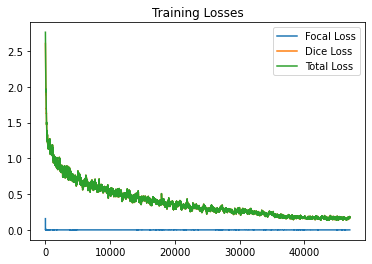

In [ ]:
### plotting train losses
tl = np.load('totalloss_train.npy', allow_pickle=True)
dl = np.load('diceloss_train.npy', allow_pickle=True)
fl = np.load('focalloss_train.npy', allow_pickle=True)
plt.plot(fl, label = "Focal Loss")


plt.plot(smooth(dl, 0.98), label = "Dice Loss")
plt.plot(smooth(tl, 0.98), label = "Total Loss")
plt.title("Training Losses")
plt.legend()
plt.show()


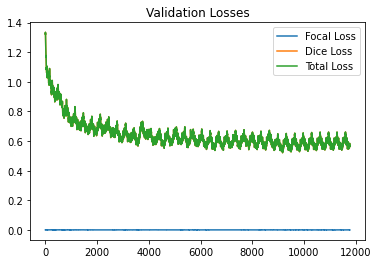

In [ ]:
### plotting val losses
tl = np.load('totalloss_val.npy', allow_pickle=True)
dl = np.load('diceloss_val.npy', allow_pickle=True)
fl = np.load('focalloss_val.npy', allow_pickle=True)
plt.plot(fl, label = "Focal Loss")
plt.plot(smooth(dl, 0.98), label = "Dice Loss")
plt.plot(smooth(tl, 0.98), label = "Total Loss")
plt.title("Validation Losses")
plt.legend()
plt.show()


In [ ]:
## plotting infer
def PlotInfer(NMS_sorted_scores_list,
                  NMS_sorted_cate_label_list,
                  NMS_sorted_ins_list,
                  color_list,
                  img,
                  count):

      for i in range(img.shape[0]):
          combined_mask = np.zeros((img.shape[2],img.shape[3],img.shape[1]))
          j=0
          for j in range(NMS_sorted_scores_list[i].shape[0]):
            l = NMS_sorted_cate_label_list[i][j]            
            if(NMS_sorted_scores_list[i][j]>0.3):
              if l == 1:
                combined_mask[:,:,0] += NMS_sorted_ins_list[i][j].cpu().numpy()
              if l == 2:
                combined_mask[:,:,1] += NMS_sorted_ins_list[i][j].cpu().numpy()
              if l == 3:
                combined_mask[:,:,2] += NMS_sorted_ins_list[i][j].cpu().numpy()
          
          if((j>0 and count<3) or (j==0 and count>2)):
            masked_image = copy.deepcopy(img[i]).cpu().numpy()
            masked_image = masked_image.transpose((1,2,0))
            index_to_mask = np.where(combined_mask > 0)
            masked_image[index_to_mask[0],index_to_mask[1],:] = 0
            mask_to_plot = (combined_mask + masked_image)
            background = img[i].cpu().numpy()
            background = background.transpose((1,2,0))

            plt.imshow(background)
            plt.imshow(mask_to_plot,alpha = 0.5)
            plt.show()
            count+=1
          return count

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


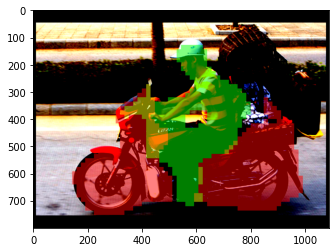

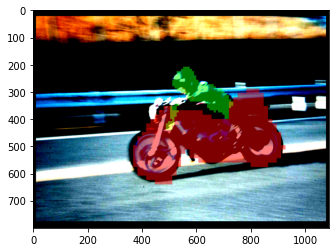

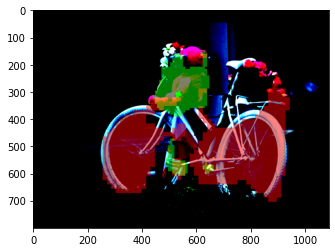

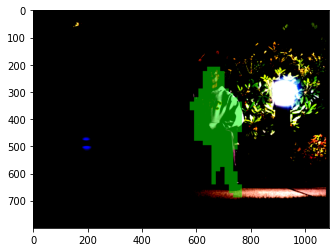

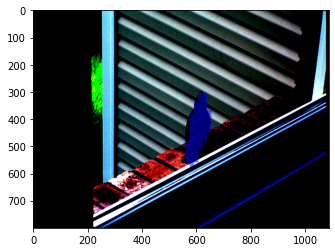

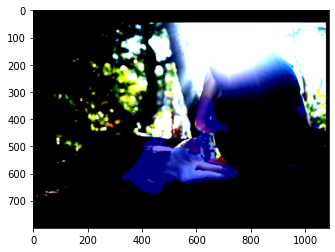

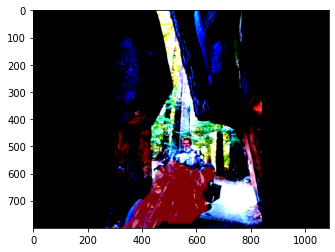

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
solo = SOLO().to(device)
checkpoint = torch.load("/content/drive/My Drive/HW3/yolo_epoch35")
solo.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.SGD(solo.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
count=0
with torch.no_grad():
    solo.eval()
    for test_iter, test_data in enumerate(test_loader, 0):
      img, label_list, mask_list, bbox_list = [test_data[i] for i in range(len(test_data))]
      img = img.to(device)
    
      cate_pred_list, ins_pred_list = solo.forward(img, eval=True)

      NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list = concat_sort(ins_pred_list, cate_pred_list, (img.shape[2],img.shape[3]))
      count = PlotInfer(NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list, ["jet", "ocean", "Spectral"], img, count)
      
      del img, label_list, mask_list, bbox_list, cate_pred_list, ins_pred_list
      torch.cuda.empty_cache()
      if count==7:
        break